Importing

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Load the dataset
data = pd.read_csv('synthetic_hospital_data_updated.csv')

# Drop the 'Patient ID' as it is not relevant for clustering
data = data.drop('Patient ID', axis=1)
data.head()


,Age,Gender,Medical History,Number of Visits,Total Medical Expenses,Treatment Adherence Score,Disease Type,Severity Level,Age Group,Chronic Condition,Treatment Plan
0,23,Female,Chronic Kidney Disease,16,19185,1,Kidney Disease,Severe,19-35,1,Ongoing
1,26,Male,Hypertension,1,1444,8,Cardiovascular Disease,Mild,19-35,1,Short-term
2,74,Male,Arthritis,16,2552,33,Musculoskeletal Disease,Severe,66+,0,Ongoing
3,48,Male,Cancer,6,11042,68,Cancer,Moderate,36-50,0,Long-term
4,38,Male,Hypertension,14,8203,50,Cardiovascular Disease,Moderate,36-50,1,Long-term


Preprocessing

In [13]:
# Define preprocessing for numeric and categorical features
numeric_features = ['Age', 'Number of Visits', 'Total Medical Expenses', 'Treatment Adherence Score']
categorical_features = ['Gender', 'Medical History']

# Create transformers
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(data)

C:\Users\Arjun\AppData\Local\Temp\ipykernel_23116\2596282984.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr=data.corr()


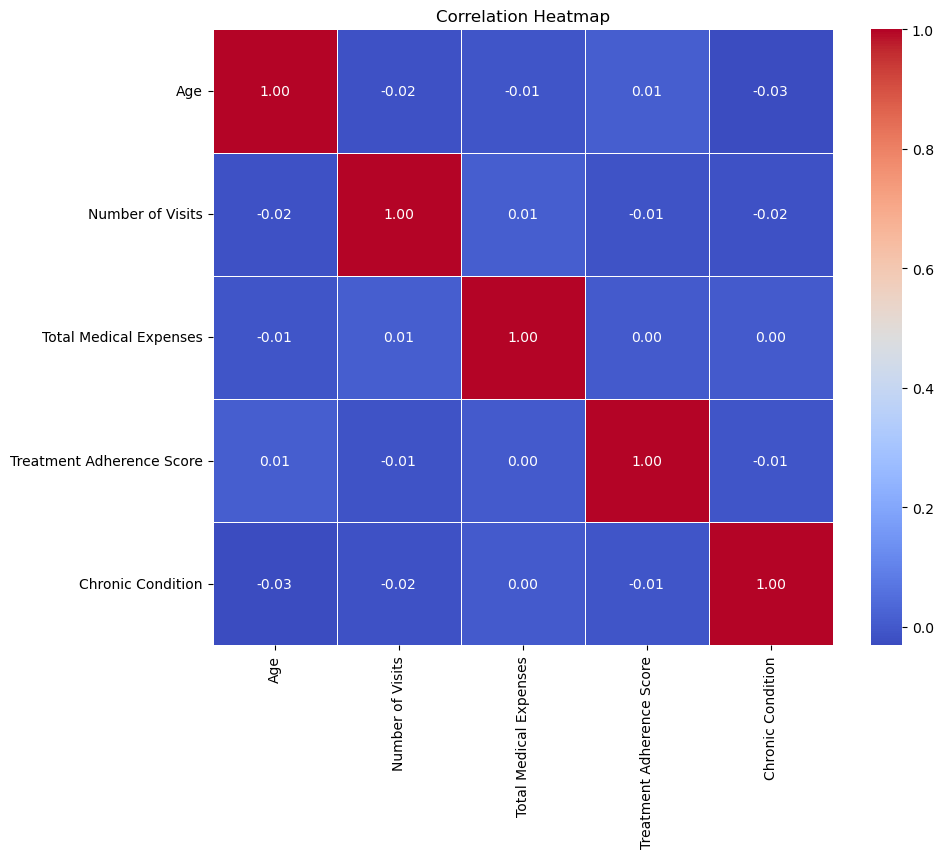

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
corr=data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


PCA

In [15]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensions
pca = PCA(n_components=5)  # Assuming we want to keep the first 5 components
X_pca = pca.fit_transform(X_preprocessed)

# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
print("Explained variance ratio:", explained_variance)
print("Cumulative explained variance:", cumulative_variance)


Explained variance ratio: [0.19094783 0.18605576 0.18318884 0.18221866 0.09277377]
Cumulative explained variance: [0.19094783 0.3770036  0.56019244 0.74241109 0.83518486]


Choosing K and clustering

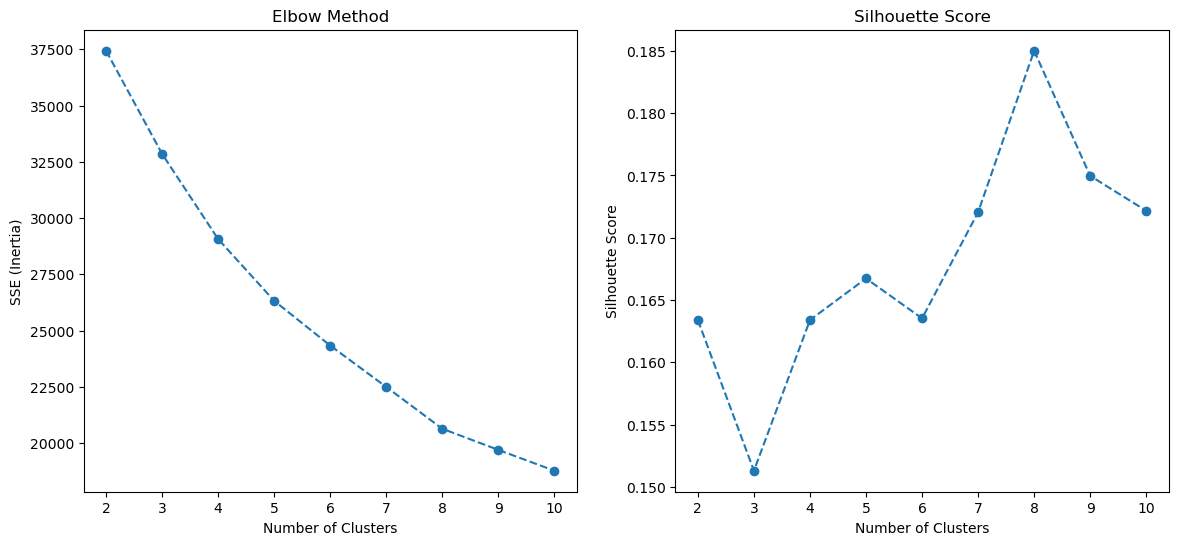

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
cluster_range = range(2, 11)
sse = []
silhouette_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(X_pca)
    sse.append(kmeans.inertia_)
    
    if len(np.unique(cluster_labels)) > 1:  # Ensure more than one cluster
        score = silhouette_score(X_pca, cluster_labels)
    else:
        score = None  # Placeholder for invalid scores
    
    silhouette_scores.append(score)

# Plot Elbow Method
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, sse, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method')

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')

plt.show()



In [17]:
# Choose optimal number of clusters based on Elbow Method and Silhouette Score
optimal_n_clusters = 8
kmeans = KMeans(n_clusters=optimal_n_clusters, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

# Add cluster labels to the original DataFrame
data['Cluster'] = cluster_labels


Plotting Cluster

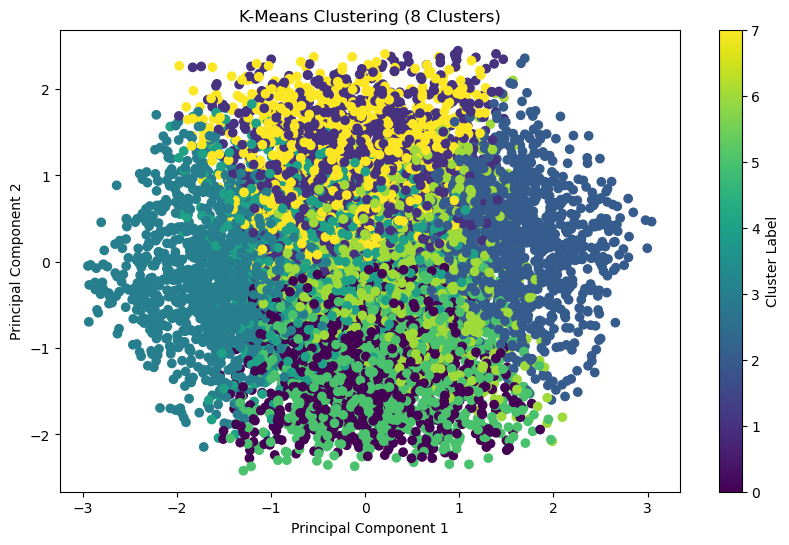

In [18]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', marker='o')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering (8 Clusters)')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

3D PLot

In [19]:
import plotly.express as px
import webbrowser
import os

# Create a DataFrame with the first three principal components
df_pca = pd.DataFrame(X_pca[:, :3], columns=['PC1', 'PC2', 'PC3'])
df_pca['Cluster'] = cluster_labels

# Create the interactive 3D scatter plot
fig = px.scatter_3d(df_pca, x='PC1', y='PC2', z='PC3',
                    color='Cluster',
                    title='3D Scatter Plot of K-Means Clusters',
                    labels={'PC1': 'Principal Component 1',
                            'PC2': 'Principal Component 2',
                            'PC3': 'Principal Component 3'})

fig.write_html('3d_scatter_plot.html')
webbrowser.open(os.path.abspath('3d_scatter_plot.html'))

True

Accuracy

In [20]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

# Silhouette Score
silhouette_avg = silhouette_score(X_pca, cluster_labels)
print(f'Silhouette Score: {silhouette_avg}')

# Calinski-Harabasz Index
calinski_harabasz = calinski_harabasz_score(X_pca, cluster_labels)
print(f'Calinski-Harabasz Index: {calinski_harabasz}')

# Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(X_pca, cluster_labels)
print(f'Davies-Bouldin Index: {davies_bouldin}')


Silhouette Score: 0.1850177028088577
Calinski-Harabasz Index: 1685.5824840624405
Davies-Bouldin Index: 1.2975922612560529


Silhouette Score (0.185): The clusters are not well-separated, indicating potential overlap or suboptimal clustering.

Calinski-Harabasz Index (1685.58): There is some density and separation in the clusters, but further improvements may be needed.

Davies-Bouldin Index (1.297): The clusters are moderately separated, suggesting room for enhanced cluster definition.

In [21]:
from sklearn.metrics import pairwise_distances_argmin_min


centroids = kmeans.cluster_centers_
# Calculate the Euclidean and Manhattan distances of each point to its cluster centroid
euclidean_distances = np.linalg.norm(X_pca - centroids[cluster_labels], axis=1)
manhattan_distances = np.abs(X_pca - centroids[cluster_labels]).sum(axis=1)

# Add these distances to the DataFrame
data['Euclidean Distance'] = euclidean_distances
data['Manhattan Distance'] = manhattan_distances

# Display the DataFrame with distances
print(data[['Cluster', 'Euclidean Distance', 'Manhattan Distance']].head())


   Cluster  Euclidean Distance  Manhattan Distance
0        3            1.575055            2.897122
1        1            1.624971            3.320682
2        7            1.016256            1.913355
3        5            1.069375            2.191939
4        4            1.187984            2.492108


In [22]:
# Check unique cluster labels
unique_clusters = data['Cluster'].unique()
print("Unique clusters present:", unique_clusters)


Unique clusters present: [3 1 7 5 4 6 0 2]


In [23]:
# Display one example from each cluster
sample_from_each_cluster = data.groupby('Cluster').head(1)
print(sample_from_each_cluster[['Cluster', 'Euclidean Distance', 'Manhattan Distance']])


    Cluster  Euclidean Distance  Manhattan Distance
0         3            1.575055            2.897122
1         1            1.624971            3.320682
2         7            1.016256            1.913355
3         5            1.069375            2.191939
4         4            1.187984            2.492108
6         6            1.680681            3.174276
7         0            1.110885            2.209624
14        2            1.034039            2.133465


In [25]:
# Summary statistics for each cluster
cluster_summary = data.groupby('Cluster').agg({
    'Age': ['mean', 'std'],
    'Number of Visits': ['mean', 'std'],
    'Total Medical Expenses': ['mean', 'std'],
    'Treatment Adherence Score': ['mean', 'std']
})

cluster_summary.head()



Age            Number of Visits            \
              mean        std             mean       std   
Cluster                                                    
0        69.882637  13.042750        14.414791  3.361555   
1        37.175610  13.106998         5.854472  3.389899   
2        71.601926  12.246549         5.979936  3.523472   
3        36.249233  12.484588        14.055982  3.540893   
4        36.752159  12.771371        14.044041  3.511526   

        Total Medical Expenses              Treatment Adherence Score  \
                          mean          std                      mean   
Cluster                                                                 
0                 14927.671222  3402.843111                 71.610932   
1                  5620.367480  3446.583190                 28.958537   
2                  5796.137239  3467.259303                 71.906902   
3                 14534.145706  3629.590103                 27.210890   
4                  5875.737478  3509.121235                 74.342832   

                    
               std  
Cluster             
0        18.395356  
1        18.595320  
2        18.750854  
3        17.733964  
4        17.702548